In [1]:
import numpy as np
from brian2 import *
from random import randrange
import math

In [2]:
def make_poisson_pattern_current(N , patterns , duration , delta_time , possibility):
    l = 0
    for i in patterns:
        if max(i) > l:
            l = max(i)
            
    which_neuron = []
    spike_time = []
    pattern_time = []
    which_pattern = []
    
    pre = 0
    for i in range (int(duration/ms /(delta_time/ms *l))):
        base = i*l
        choice = np.random.choice([1,0],p=[possibility , 1-possibility])
        
        if pre == 1:
            choice = 0
            pre = 0
            
        if choice == 1:
            pre = 1
            pattern_time.append(base * delta_time/ms)
            pattern_number = randrange(len(patterns))
            which_pattern.append(pattern_number)
            
        for j in range(N):
            if choice == 0:
                rand = randrange(0,l+1)
                if rand == 0:
                    continue
                spike_time.append((base + rand)*(delta_time/ms) * ms)
                which_neuron.append(j)
                
            if choice == 1:
                if patterns[pattern_number][j] != 0:
                    which_neuron.append(j)
                    spike_time.append((base + patterns[pattern_number][j])*(delta_time/ms)* ms)
    
    return which_neuron , spike_time , pattern_time , which_pattern , l*delta_time/ms

In [3]:
def pulse_input_current_generator(max_I,delta_time,duration,possibility):
    output = TimedArray([np.random.choice([max_I,0],p=[possibility,1 - possibility]) * namp for i in range(int(duration/delta_time))],delta_time)
    return output

In [7]:
def simulate (duration = 200*ms , Apre=2 , I_1 = 2 * Mohm , p_1 = 0.1 , I_2 = 2 * Mohm , p_2 = 0.1 , p_pattern = 0.40 , tau_pre = 12*ms 
              , u_rest_post_1 = -70 * mV, tau_post_1 = 14 * ms , threshold_post_1 = -55 * mV , Resistance_post_1 = 8 * Mohm
              , u_rest_post_2 = -70 * mV, tau_post_2 = 11 * ms , threshold_post_2 = -55 * mV , Resistance_post_2 = 6 * Mohm):
    
    start_scope()
    delta_time = 0.5 * ms
    wmax = 1
#     Apost = -Apre * tau_pre / tau_post_1
    Apost = -Apre
    
    which_neuron , spike_time , pattern_time , which_pattern , l= make_poisson_pattern_current(10 , [[7,0,4,4,9,1,0,5,4,2],[6,4,8,2,7,5,9,1,3,5]] , duration , delta_time , p_pattern)
    pre = SpikeGeneratorGroup(10, which_neuron, spike_time)
    
    input_current_post_1 = pulse_input_current_generator(I_1 , delta_time , duration , p_1)
    input_current_post_2 = pulse_input_current_generator(I_2 , delta_time , duration , p_2)
    
    eqs_post_1 = '''
        du/dt = -(u-u_rest)/tau + Resistance * input_current_post_1(t)/tau : volt
        tau : second
        u_rest : volt
        Resistance : ohm
    '''
    post_1 = NeuronGroup(1,eqs_post_1,threshold='u>threshold_post_1', reset='u=u_rest_post_1',method='linear')
    
    post_1.u = u_rest_post_1
    post_1.tau = tau_post_1
    post_1.u_rest = u_rest_post_1
    post_1.Resistance = Resistance_post_1
    
    eqs_post_2 = '''
        du/dt = -(u-u_rest)/tau + Resistance * input_current_post_2(t)/tau : volt
        tau : second
        u_rest : volt
        Resistance : ohm
    '''
    post_2 = NeuronGroup(1,eqs_post_2,threshold='u>threshold_post_2', reset='u=u_rest_post_2',method='linear')
    
    post_2.u = u_rest_post_2
    post_2.tau = tau_post_2
    post_2.u_rest = u_rest_post_2
    post_2.Resistance = Resistance_post_2
    
    syn_1 = Synapses (pre , post_1 ,
             '''
             w : 1
             dapre/dt = -apre/tau_pre : 1 
             dapost/dt = -apost/tau_post_1 : 1 
             ''' ,
             on_pre= '''
             u_post += w*5 * mV
             apre += Apre
             w = clip(w+apost, 0, wmax) 
             ''' ,
             on_post='''
             apost += Apost
             w = clip(w+apre, 0, wmax)
             ''')
    
    syn_1.connect(p=1)
    syn_1.w = [0.4 + random()*0.2 for i in range(10)]
    
    syn_2 = Synapses (pre , post_2 ,
             '''
             w : 1
             dapre/dt = -apre/tau_pre : 1 
             dapost/dt = -apost/tau_post_2 : 1 
             ''' ,
             on_pre= '''
             u_post += w*5 * mV
             apre += Apre
             w = clip(w+apost, 0, wmax) 
             ''' ,
             on_post='''
             apost += Apost
             w = clip(w+apre, 0, wmax)
             ''')
    
    syn_2.connect(p=1)
    syn_2.w = [0.4 + random()*0.2 for i in range(10)]
    
    u_mon_1 = StateMonitor(post_1 , 'u' , record = True)
    u_mon_2 = StateMonitor(post_2 , 'u' , record = True)
    
    M_1 = StateMonitor(syn_1, ['w', 'apre', 'apost'], record=True)
    M_2 = StateMonitor(syn_2, ['w', 'apre', 'apost'], record=True)
    
    s1_1 = SpikeMonitor(post_1)
    s1_2 = SpikeMonitor(post_2)
    s2 = SpikeMonitor(pre)
    
    run(duration)
    
    figure(figsize=(14, 14))
    subplot(711)
#     plot(u_mon.t/ms , u_mon.u[0]/mV, label = '0')
#     plot(u_mon.t/ms , u_mon.u[1]/mV, label = '1')
#     for i in range (len(pattern_time)):
#         if which_pattern[i] == 0:
#             axvspan(pattern_time[i] , pattern_time[i]+l, alpha=0.2, color='red')
#         else:
#             axvspan(pattern_time[i] , pattern_time[i]+l, alpha=0.2, color='blue')
#     for i in range(2):
    plot(M_1.t/ms, M_1.apre[1], label='apre '+str(0))
    plot(M_1.t/ms, M_1.apost[1], label='apost '+str(0))
    plt.axhline(color='red')
        
#     for i in range (len(pattern_time)):
#         if which_pattern[i] == 0:
#             axvspan(pattern_time[i] , pattern_time[i]+l, alpha=0.2, color='red')
#         else:
#             axvspan(pattern_time[i] , pattern_time[i]+l, alpha=0.2, color='blue')
    legend()
    subplot(712)
    plt.axhline(y=u_rest_post_1/mV , color='red')
    plt.axhline(y=threshold_post_1/mV , color='red')
#     post_1_spike_times = sorted(list(flatten([list(list(s1.all_values()['t'][0])/ms)])))
#     post_2_spike_times = sorted(list(flatten([list(list(s1.all_values()['t'][1])/ms)])))
    
#     plot(list(Counter(post_1_spike_times).keys()) ,list(Counter(post_1_spike_times).values()),label = 'post1')
#     plot(list(Counter(post_2_spike_times).keys()) ,list(Counter(post_2_spike_times).values()),label = 'post2')
#     for i in range(10):
#     plot(M.t/ms, M.w[0], label='w')
#     legend(loc='best')
#     xlabel('Time (ms)')
#     ylabel('W (mV)')
    plot(u_mon_1.t/ms , u_mon_1.u[0]/mV, label = '0')
#     plot(u_mon.t/ms , u_mon.u[1]/mV, label = '1')
    legend()
#     plot(u_mon.t/ms , u_mon.u[4], label = '1')
    for i in range (len(pattern_time)):
#         if pattern_time[i] < duration/ms - last:
#             continue
        if which_pattern[i] == 0:
            axvspan(pattern_time[i] , pattern_time[i]+l, alpha=0.2, color='red')
        else:
            axvspan(pattern_time[i] , pattern_time[i]+l, alpha=0.2, color='blue')
            
    subplot(713)
    plt.axhline(y=u_rest_post_1/mV , color='red')
    plt.axhline(y=threshold_post_1/mV , color='red')
#     last = int(duration/ms * delta_time/ms / 10)
#     if last > 500:
#         last = 500

    last = 100
        
    plot(u_mon_1.t[-last*10:-1]/ms , u_mon_1.u[0][-last*10:-1]/mV, label = '0')
    for i in range (len(pattern_time)):
        if pattern_time[i] < duration/ms - last:
            continue
        if which_pattern[i] == 0:
            axvspan(pattern_time[i] , pattern_time[i]+l, alpha=0.2, color='red')
        else:
            axvspan(pattern_time[i] , pattern_time[i]+l, alpha=0.2, color='blue')
            
    subplot(714)
    plt.axhline(y=u_rest_post_2/mV , color='red')
    plt.axhline(y=threshold_post_2/mV , color='red')
    plot(u_mon_2.t[-last*10:-1]/ms , u_mon_2.u[0][-last*10:-1]/mV, label = '1',color = 'orange')
    for i in range (len(pattern_time)):
        if pattern_time[i] < duration/ms - last:
            continue
        if which_pattern[i] == 0:
            axvspan(pattern_time[i] , pattern_time[i]+l, alpha=0.2, color='red')
        else:
            axvspan(pattern_time[i] , pattern_time[i]+l, alpha=0.2, color='blue')
            
    subplot(715)
    plot(M_1.t[-last*10:-1]/ms, M_1.w[1][-last*10:-1], label='w_0')
#     plot(M.t[-last*10:-1]/ms, M.w[10][-last*10:-1], label='w_1')
    legend()
#     plot(M.t/ms, M.w[2], label='w')
#     plot(M.t/ms, M.w[3], label='w')
#     plot(M.t/ms, M.w[4], label='w')
    subplot(716)
    plot(s1_1.t/ms,s1_1.i, 'ok', ms=1)
    plot(s1_2.t/ms,[x+1 for x in s1_2.i], 'ok', ms=1)
    for i in range (len(pattern_time)):
#         if pattern_time[i] < duration/ms - last:
#             continue
        if which_pattern[i] == 0:
            axvspan(pattern_time[i] , pattern_time[i]+l, alpha=0.2, color='red')
        else:
            axvspan(pattern_time[i] , pattern_time[i]+l, alpha=0.2, color='blue')
    subplot(717)
    plot(s2.t/ms,s2.i, 'ok', ms=1)
    for i in range (len(pattern_time)):
#         if pattern_time[i] < duration/ms - last:
#             continue
        if which_pattern[i] == 0:
            axvspan(pattern_time[i] , pattern_time[i]+l, alpha=0.2, color='red')
        else:
            axvspan(pattern_time[i] , pattern_time[i]+l, alpha=0.2, color='blue')
#     return s1
    return M_1 , M_2 , s1_1 , s1_2 , s2 , pattern_time , which_pattern , which_neuron , spike_time , u_mon_1 , u_mon_2

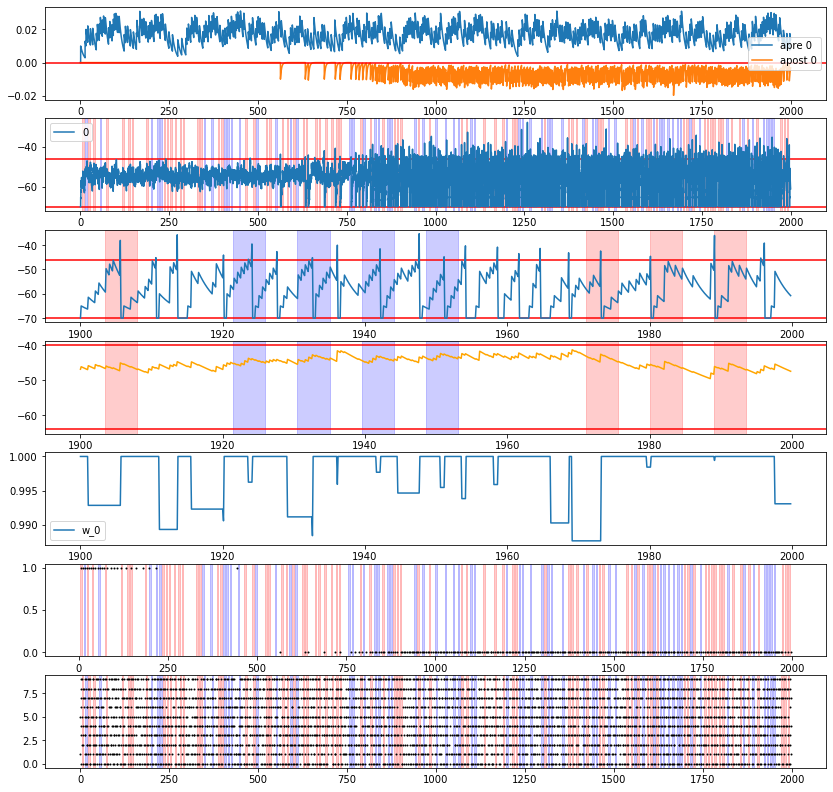

In [19]:
M_1 , M_2 , s1_1 , s1_2 , s2 , pattern_time , which_pattern , which_neuron , spike_time , u_mon_1 , u_mon_2 = simulate (
    duration = 2000*ms , Apre=0.01 , I_1 = 0 * Mohm , p_1 = 0 , I_2 = 0 * Mohm , p_2 = 0 , p_pattern = 0.5 , tau_pre =10*ms 
              , u_rest_post_1 = -70 * mV, tau_post_1 = 3 * ms , threshold_post_1 = -46 * mV , Resistance_post_1 = 10 * Mohm
              , u_rest_post_2 = -64 * mV, tau_post_2 = 19 * ms , threshold_post_2 = -40 * mV , Resistance_post_2 = 10 * Mohm)

In [16]:
u_mon_1.u

array([[-70.        , -70.        , -70.        , ..., -64.65388711,
        -64.91462012, -65.16263702]]) * mvolt

In [19]:
pattern_time

[0.0,
 36.0,
 54.0,
 81.0,
 99.0,
 117.0,
 144.0,
 171.0,
 198.0,
 216.0,
 234.0,
 270.0,
 288.0,
 306.0,
 333.0,
 351.0,
 369.0,
 405.0,
 423.0,
 441.0,
 486.0,
 504.0,
 549.0,
 567.0,
 603.0,
 621.0,
 639.0,
 657.0,
 684.0,
 711.0,
 738.0,
 765.0,
 792.0,
 819.0,
 864.0,
 900.0,
 918.0,
 936.0,
 954.0,
 972.0,
 990.0,
 1026.0,
 1044.0,
 1062.0,
 1080.0,
 1098.0,
 1125.0,
 1143.0,
 1161.0,
 1179.0,
 1233.0,
 1251.0,
 1269.0,
 1296.0,
 1314.0,
 1350.0,
 1368.0,
 1404.0,
 1431.0,
 1449.0,
 1476.0,
 1512.0,
 1530.0,
 1548.0,
 1566.0,
 1584.0,
 1611.0,
 1629.0,
 1647.0,
 1683.0,
 1719.0,
 1737.0,
 1755.0,
 1773.0,
 1791.0,
 1809.0,
 1836.0,
 1854.0,
 1890.0,
 1908.0,
 1926.0,
 1953.0,
 1980.0,
 2007.0,
 2034.0000000000002,
 2061.0,
 2097.0,
 2115.0,
 2133.0,
 2151.0,
 2169.0,
 2214.0,
 2250.0,
 2286.0,
 2304.0,
 2322.0,
 2340.0,
 2358.0,
 2376.0,
 2430.0,
 2448.0,
 2475.0,
 2493.0,
 2511.0,
 2529.0,
 2547.0,
 2565.0,
 2592.0,
 2673.0,
 2709.0,
 2736.0,
 2763.0,
 2799.0,
 2835.0,
 2853.0,
